# Sample 4A-2: Model fitting

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

## Linear fitting

 final_simplex: (array([[0.52596714, 2.02217187],
       [0.52590325, 2.02213177],
       [0.52586959, 2.02223292]]), array([8.63953003, 8.6395326 , 8.63953728]))
           fun: 8.639530030308268
       message: 'Optimization terminated successfully.'
          nfev: 129
           nit: 67
        status: 0
       success: True
             x: array([0.52596714, 2.02217187])
----------------------------------------
a=0.5259, b=2.0222 
covariance matrix= [[ 0.00087603 -0.00041678]
 [-0.00041678  0.00222055]]


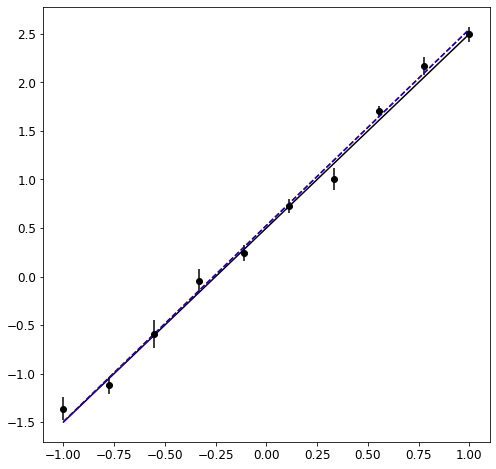

In [36]:
from scipy.optimize import minimize, curve_fit

x1 = np.linspace(-1,1,10)
e1 = np.random.rand(10)*0.1+0.05
y1 = 0.5 + 2.*x1+np.random.normal(0,e1)

def linearfunc(x,a,b):
    return a+b*x
def chi2(x,x1,y1,s_y1):
    return np.sum(((y1-linearfunc(x1,x[0],x[1]))/s_y1)**2)

#################minimize chi-square
# initial point may change the result
res = minimize(chi2, [0,0], args=(x1,y1,e1),method='Nelder-Mead')
print(res)
print('----------------------------------------')
#################curve fit
ppot, pcov = curve_fit(linearfunc, x1,y1, p0=[0,0],sigma=e1)
print('a={:.4f}, b={:.4f}'.format(ppot[0],ppot[1]),'\ncovariance matrix=',pcov)

x2 = np.linspace(-1,1,1000)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.errorbar(x1,y1,yerr=e1,fmt='ko')
ax.plot(x2, 0.5+2.*x2,'k-')
ax.plot(x2,linearfunc(x2,res.x[0],res.x[1]),'r--')
ax.plot(x2,linearfunc(x2,ppot[0],ppot[1]),'b--')

In [ ]:
## 

##  Gaussian process regressor

0.9999999999813227


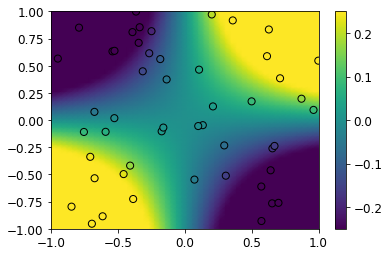

In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor as gpr

x = np.random.rand(50)*2 - 1.
y = np.random.rand(50)*2 - 1.
d = np.concatenate((x.reshape(50,1),y.reshape(50,1)),axis=1)
z =x*y
xgrid = np.mgrid[-1:1:50j,-1:1:50j]

f = gpr().fit(d,z)
print(f.score(d,z))

xgrid = np.mgrid[-1:1:50j,-1:1:50j]

xflat = xgrid.reshape(2, -1).T
yflat = f.predict(xflat)
ygrid = yflat.reshape(50, 50)

fig, ax = plt.subplots()
ax.pcolormesh(*xgrid, ygrid, vmin=-0.25, vmax=0.25, shading='gouraud')
p = ax.scatter(*d.T, c=z, s=50, ec='k', vmin=-0.25, vmax=0.25)
fig.colorbar(p)
plt.show()

C:\Users\HONOR\AppData\Local\Temp/ipykernel_29048/2305982985.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


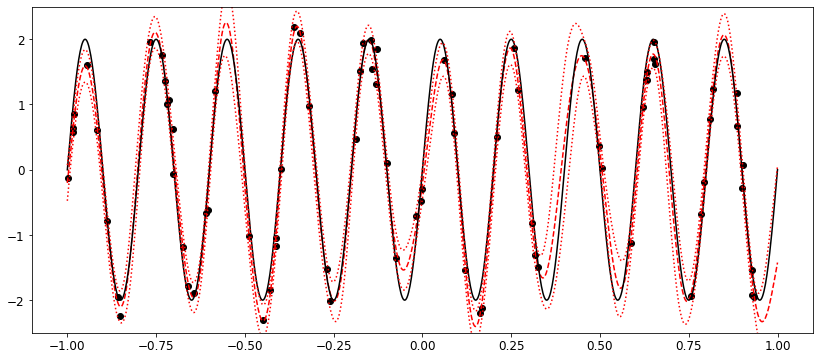

In [33]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def func1(x1):
    return np.sin(x1*np.pi*10.)*2.

#x1 = np.linspace(-1, 1, 80)
x1 = np.random.uniform(-1,1,80)
y1 = func1(x1)+np.random.rand(len(x1))*0.8-0.4

kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1))
f = gpr(kernel=kernel, alpha=0).fit(x1.reshape(-1,1),y1)

x2 = np.linspace(-1,1,1000)

y_mean, y_std = f.predict(x2.reshape(-1,1), return_std=True)

fig = plt.figure(figsize=[14,6])
ax = fig.add_subplot(111)
ax.plot(x1, y1,'ko')
ax.plot(x2, y_mean,'r--')
ax.plot(x2,func1(x2),'k-')
ax.plot(x2, y_mean+y_std,'r:')
ax.plot(x2, y_mean-y_std,'r:')
ax.set_ylim([-2.5,2.5])
fig.show()

## Demonstration of the issue in high-order polynomial fitting

In [59]:
import unittest
'''A 5-order polynomial'''
def poly5(x,A):
    x1 = np.array(x).reshape(-1,1)
    X = np.concatenate((np.ones_like(x1),x1,x1**2,x1**3,x1**4,x1**5),axis=1)
    Y = X*np.repeat(np.array(A).reshape(1,-1),x1.shape[0],axis=0)
    return np.sum(Y,axis=1)

'''
How to do unit test
'''
class my_test(unittest.TestCase):
    def test_A(self):
        x=3
        self.assertTrue(poly5(x,[1,2,3,2,1,2])==(1+x*2+3*x**2+2*x**3+1*x**4+2*x**5))
        print('test A (x=3) passed.')
        
    def test_B(self):
        x=[3]
        self.assertTrue(poly5(x,[1,2,3,2,1,2])[0]==(1+x[0]*2+3*x[0]**2+2*x[0]**3+1*x[0]**4+2*x[0]**5))
        print('test B (x=[3]) passed.')

    def test_C(self):
        x=np.array([-1,5,3,7])
        a = poly5(x,[1,2,3,2,1,2])
        b = (1+x*2+3*x**2+2*x**3+1*x**4+2*x**5)
        self.assertTrue(a.all()==b.all())
        print('test C (x=[-1,5,3,7]) passed.')
        
    def run(self):
        self.test_A()
        self.test_B()
        self.test_C()
        
test = my_test()
test.run()

test A (x=3) passed.
test B (x=[3]) passed.
test C (x=[-1,5,3,7]) passed.


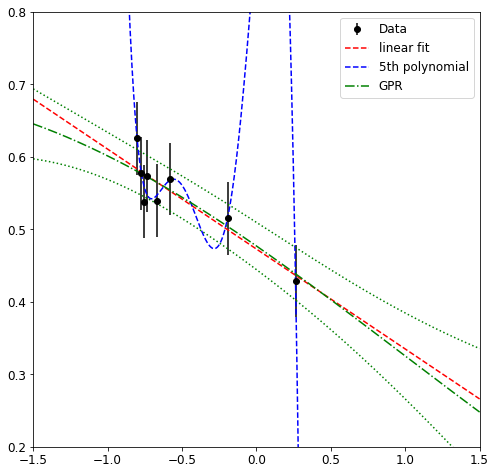

In [93]:
x =np.random.uniform(-1,1,8)
y = 0.5-0.1*x+ np.random.rand(len(x))*0.1-0.05

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
e1 = ax.errorbar(x,y,yerr=0.05,fmt='ko')
ax.set_xlim(-1.5,1.5)
ax.set_ylim([0.2,0.8])
x2 = np.linspace(-1.5,1.5,1000)
## a linear fit
ppot,pcov = curve_fit(linearfunc,x,y,p0=[0,0])
e2, = ax.plot(x2,linearfunc(x2,ppot[0],ppot[1]),'r--')

##a 5-order polynomial fit
def p5func(x, a, b, c, d, e, f):
    return poly5(x,np.array([a,b,c,d,e,f]))

ppot,pcov = curve_fit(p5func,x,y,p0=[0,0,0,0,0,0])
e3, = ax.plot(x2,poly5(x2,ppot),'b--')

## Gauss process
f = gpr(kernel=kernel, alpha=0).fit(x.reshape(-1,1),y)
y_mean, y_std = f.predict(x2.reshape(-1,1), return_std=True)
e4, = ax.plot(x2,y_mean,'g-.')
ax.plot(x2,y_mean+y_std,'g:')
ax.plot(x2,y_mean-y_std,'g:')

plt.legend([e1,e2,e3,e4],['Data','linear fit','5th polynomial','GPR'], fontsize=12)

## Using Optimization algorithm for genetic model fitting

 final_simplex: (array([[9.96104118, 0.2207513 ],
       [9.96099337, 0.22078028],
       [9.960973  , 0.22074475]]), array([22.01098447, 22.01098462, 22.01098512]))
           fun: 22.010984471399375
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 65
        status: 0
       success: True
             x: array([9.96104118, 0.2207513 ])
MCMC result: w=9.9626+/-0.0357, shift=0.2211+/-0.0319


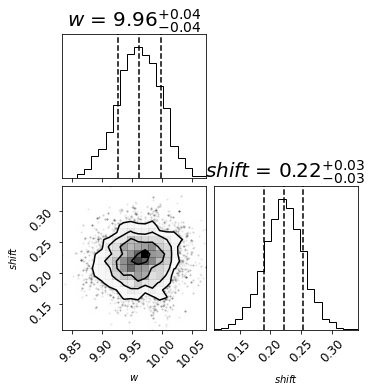

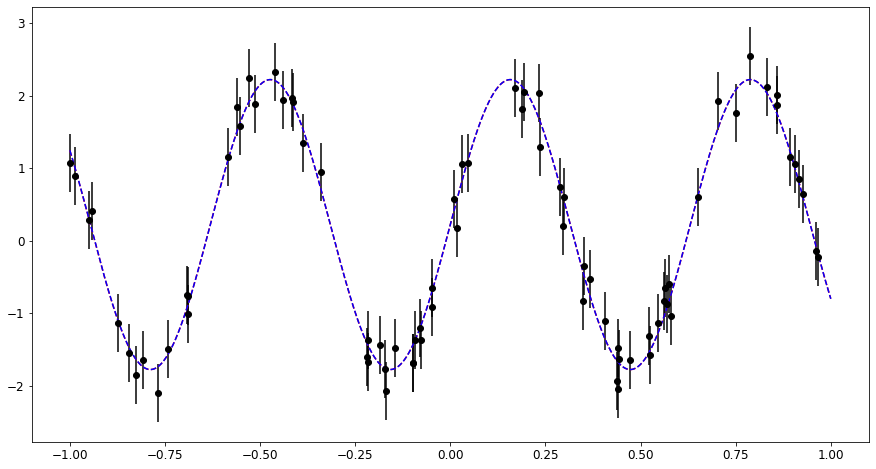

In [30]:
from scipy.optimize import minimize
import emcee
import corner

def func1(x1, w):
    return np.sin(x1*w[0])*2.+w[1]

def chi2(x, x1, y1):
    return np.sum((y1-func1(x1,x))**2/0.4**2)

def lnprob(x,x1,y1):
    return -chi2(x,x1,y1)

#x1 = np.linspace(-1, 1, 80)
x1 = np.random.uniform(-1,1,80)
y1 = func1(x1, [10.,0.2])+np.random.rand(len(x1))*0.8-0.4

'''
Using minimize
'''
res = minimize(chi2, [6.,0.], args=(x1,y1), method='Nelder-Mead')
print(res)

'''
Using MCMC
'''
nwalkers = 10
ndim = 2
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = np.random.rand(nwalkers)*6.+7.
p0[:,1] = np.random.rand(nwalkers)*5.-2.5

sampler = emcee.EnsembleSampler(nwalkers, \
        ndim, lnprob, args=[x1,y1])
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
sampler.run_mcmc(pos, 1000)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
fig = corner.corner(samples,labels=[r"$w$", r"$shift$"],\
                       quantiles=[0.16, 0.5, 0.84],\
                       show_titles=True,\
                       title_kwargs={"fontsize": 20})
x_mcmc = np.mean(samples,axis=0)
xerr_mcmc = np.std(samples,axis=0)
print('MCMC result: w={:.4f}+/-{:.4f}, shift={:.4f}+/-{:.4f}'.format(\
    x_mcmc[0],xerr_mcmc[0],x_mcmc[1],xerr_mcmc[1]))


'''
Draw results
'''
x2 = np.linspace(-1,1,1000)
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111)
ax.errorbar(x1,y1,yerr=0.4,fmt='ko')
ax.plot(x2, func1(x2,res.x),'r--')
ax.plot(x2, func1(x2,x_mcmc),'b--')
